# 3. Modeling

Notebook ini mengasumsikan bahwa dataset bersih sudah disimpan sebelumnya sebagai file:

`./Dataset/UsedCarsSA_Clean.csv`

Jika belum ada, jalankan terlebih dahulu notebook notebook 02 untuk menghasilkan file tersebut.

In [1]:
# 3.1 Import library dan load dataset bersih
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, cross_validate
import time

import shap

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load dataset bersih
data_path_clean = '../Dataset/UsedCarsSA_Clean.csv'
real_df = pd.read_csv(data_path_clean)
df = real_df.copy()

df.head()

,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Price,Car_Age,Mileage_per_Year
0,Chrysler,C300,2018,Saudi,Black,Full,5.7,Gas,Automatic,103000,Riyadh,114000.0,7,12875.000000
1,Nissan,Sunny,2019,Saudi,Silver,Standard,1.5,Gas,Automatic,72418,Riyadh,27500.0,6,10345.428571
2,Hyundai,Elantra,2019,Saudi,Grey,Standard,1.6,Gas,Automatic,114154,Riyadh,43000.0,6,16307.714286
3,Hyundai,Elantra,2019,Saudi,Silver,Semi Full,2.0,Gas,Automatic,41912,Riyadh,59500.0,6,5987.428571
4,Honda,Accord,2018,Saudi,Navy,Full,1.5,Gas,Automatic,39000,Riyadh,72000.0,7,4875.000000


## 3.1 Menyiapkan Fitur dan Target

In [2]:
# Definisikan target dan fitur
target = 'Price'
X = df.drop(columns=[target])
y = df[target]

In [3]:
y.head()

0    114000.0
1     27500.0
2     43000.0
3     59500.0
4     72000.0
Name: Price, dtype: float64

Pada tahap ini, kolom **Price** ditetapkan sebagai **target (y)** karena merepresentasikan harga mobil yang ingin diprediksi, sedangkan **fitur (X)** terdiri dari seluruh kolom selain Price yang menggambarkan karakteristik kendaraan. Fitur tersebut mencakup atribut **kategorikal** seperti *Make, Type, Origin, Color, Options, Fuel_Type, Gear_Type,* dan *Region*, serta atribut **numerik** seperti *Year, Engine_Size,* dan *Mileage*. Kombinasi fitur-fitur ini diharapkan mampu menangkap faktor utama yang memengaruhi harga mobil bekas, mulai dari spesifikasi teknis, usia kendaraan, hingga preferensi pasar berdasarkan lokasi.

## 3.2 Train–Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((3824, 13), (957, 13))

Dataset dibagi menjadi **data latih (training)** dan **data uji (testing)** dengan proporsi **80% : 20%** menggunakan `train_test_split`, di mana `random_state=42` memastikan hasil pembagian konsisten dan dapat direproduksi. Data latih digunakan untuk membangun dan melatih model, sementara data uji disisihkan untuk mengevaluasi performa model pada data yang belum pernah dilihat sebelumnya, sehingga memberikan gambaran kemampuan generalisasi model.


## 3.3 Pipeline Preprocessing

In [5]:
numeric_features = []
for col in ['Year', 'Engine_Size', 'Mileage', 'Car_Age']:
    if col in X_train.columns:
        numeric_features.append(col)

categorical_features = [col for col in X_train.columns if col not in numeric_features]
numeric_features, categorical_features[:10]  # tampilkan contoh beberapa fitur kategorikal

(['Year', 'Engine_Size', 'Mileage', 'Car_Age'],
 ['Make',
  'Type',
  'Origin',
  'Color',
  'Options',
  'Fuel_Type',
  'Gear_Type',
  'Region',
  'Mileage_per_Year'])

Fitur numerik didefinisikan sebagai `Year`, `Engine_Size`, `Mileage`, dan `Car_Age` jika memang tersedia di `X_train`, sedangkan seluruh kolom lainnya otomatis dikategorikan sebagai fitur kategorikal, termasuk atribut deskriptif kendaraan dan fitur turunan seperti `Mileage_per_Year`. Hasil ini memastikan bahwa pembagian fitur konsisten dengan pipeline preprocessing, sehingga proses imputasi, scaling, dan encoding dapat diterapkan secara tepat sesuai tipe datanya.

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Pipeline preprocessing ini memisahkan perlakuan fitur **numerik** dan **kategorikal** secara sistematis: fitur numerik diimputasi menggunakan **median** untuk mengurangi pengaruh outlier lalu diskalakan dengan **RobustScaler** agar lebih stabil terhadap distribusi yang skewed, sedangkan fitur kategorikal diimputasi dengan nilai **modus** dan dikonversi menjadi representasi numerik menggunakan **One-Hot Encoding** dengan `handle_unknown='ignore'` agar aman terhadap kategori baru pada data uji. Seluruh proses digabungkan dalam `ColumnTransformer` sehingga preprocessing berlangsung konsisten, terintegrasi langsung dengan pipeline model, dan meminimalkan risiko data leakage.

## 3.4 Cross-Validation -> Mencari Model Regresi Terbaik

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100


def evaluate_regression(model, X_train, y_train, X_test, y_test, name='Model'):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    return {
        'name': name,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

Evaluasi model regresi pada fungsi ini difokuskan pada **MAE dan MAPE** untuk menjaga penilaian performa tetap sederhana dan relevan dengan tujuan prediksi harga. **MAE** dihitung pada data latih dan data uji untuk memantau potensi **overfitting** melalui perbandingan kesalahan absolut rata-rata, sedangkan **MAPE** dihitung pada data uji untuk menilai **kesalahan relatif** model dalam bentuk persentase pada data yang belum pernah dilihat sebelumnya. Pendekatan ini memastikan evaluasi berfokus pada akurasi prediksi yang dapat diinterpretasikan secara bisnis tanpa menambahkan metrik yang tidak memberikan insight tambahan.

In [8]:
models = {
    'Linear Regression': LinearRegression(),

    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),

    'Gradient Boosting': GradientBoostingRegressor(
        random_state=42
    ),

    'XGBoost': XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
}

Untuk kasus ini, akan ada **empat model regresi sebagai kandidat benchmark** untuk memprediksi harga mobil bekas. *Linear Regression* digunakan sebagai **baseline** sederhana untuk melihat hubungan linear dasar pada data. *Random Forest Regressor* berfungsi menangkap pola non-linier dan interaksi fitur dengan pendekatan ensemble berbasis bagging. *Gradient Boosting Regressor* digunakan sebagai metode boosting klasik yang fokus memperbaiki error secara bertahap. *XGBoost Regressor* dipilih sebagai model boosting lanjutan dengan kontrol hiperparameter yang lebih fleksibel, sehingga berpotensi memberikan performa terbaik. Kumpulan model ini memungkinkan perbandingan yang adil antara baseline dan model kompleks sebelum menentukan model final.


In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 🔹 Median harga (baseline bisnis)
median_price = y_train.median()

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    start_time = time.time()

    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        return_train_score=False,
        n_jobs=-1
    )

    cv_time = time.time() - start_time

    cv_mae_scores = -cv_results['test_score']
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    pipeline.fit(X_train, y_train)

    y_test_pred = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    mae_pct_of_median_price = (test_mae / median_price) * 100

    results.append({
        'model': name,
        'cv_mae_mean': cv_mae_mean,
        'cv_mae_std': cv_mae_std,
        'cv_time_sec': cv_time,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'mae_pct_of_median_price': mae_pct_of_median_price
    })


**Performa beberapa model regresi secara sistematis** akan dibandingkan menggunakan pendekatan cross-validation dan evaluasi pada data uji. Setiap model dibungkus dalam satu pipeline yang mencakup preprocessing dan algoritma regresi, lalu dievaluasi menggunakan **5-fold K-Fold cross-validation** dengan metrik utama **MAE**. Rata-rata dan standar deviasi MAE dari CV digunakan untuk menilai stabilitas model, sementara waktu komputasi dicatat untuk membandingkan efisiensi. Setelah itu, model dilatih ulang pada seluruh data training dan diuji pada data test untuk memperoleh MAE dan MAPE sebagai gambaran performa generalisasi. Hasil evaluasi ini menjadi dasar pemilihan model terbaik sebelum dilakukan tuning dan deployment.


In [10]:
results_df = pd.DataFrame(results).sort_values('test_mae')
results_df

,model,cv_mae_mean,cv_mae_std,cv_time_sec,test_mae,test_mape,mae_pct_of_median_price
3,XGBoost,11667.193649,609.126626,2.607130,11836.828687,111.657030,20.585789
1,Random Forest,12412.367616,654.580974,8.766347,12042.706972,118.077111,20.943838
2,Gradient Boosting,14012.976773,708.901023,2.522573,14265.768521,118.046844,24.810032
0,Linear Regression,16673.627508,731.937124,2.226960,15649.539260,126.849432,27.216590


Hasil evaluasi menunjukkan bahwa **XGBoost** merupakan model dengan performa terbaik dibandingkan kandidat lain, ditandai dengan **rata-rata MAE cross-validation terendah (~11.667 SAR)** dan performa yang konsisten (deviasi relatif kecil), serta **MAE data uji ~11.837 SAR**. Random Forest berada di posisi kedua dengan error sedikit lebih tinggi namun waktu komputasi paling lama, sementara Gradient Boosting dan Linear Regression menunjukkan error yang lebih besar, menandakan keterbatasan dalam menangkap pola non-linier kompleks pada data. Berdasarkan kombinasi akurasi, stabilitas, dan efisiensi, XGBoost dipilih sebagai **model final** untuk tahap tuning lanjutan dan deployment.

## 3.5 Hyperparameter Tuning -> Mencari Parameter Terbaik dari Model Regresi Terbaik

In [11]:
from sklearn.model_selection import GridSearchCV

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'model__n_estimators': [300, 400, 600],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}


Kode tersebut menyiapkan **proses hyperparameter tuning untuk model XGBoost** menggunakan pendekatan pipeline end-to-end. Model XGBoost dibungkus bersama preprocessing dalam satu `Pipeline` agar setiap kombinasi parameter diuji secara konsisten tanpa data leakage. `param_grid` mendefinisikan ruang pencarian utama yang berpengaruh besar terhadap bias–variance trade-off, yaitu jumlah pohon, kedalaman pohon, learning rate, serta rasio subsampling baris dan fitur. Konfigurasi ini memungkinkan GridSearchCV mengeksplorasi kombinasi parameter secara sistematis untuk menemukan model dengan performa MAE terbaik sebelum dipilih sebagai model final.


In [12]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [4, 6, ...], 'model__n_estimators': [300, 400, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


Proses **GridSearchCV** berhasil dijalankan untuk melakukan hyperparameter tuning pada pipeline XGBoost dengan **108 kombinasi parameter** dan **5-fold cross-validation** (total 540 training). Hasilnya, GridSearch secara otomatis memilih kombinasi parameter terbaik berdasarkan **MAE terendah**, lalu melakukan *refit* pada seluruh data training menggunakan konfigurasi optimal tersebut. Model terbaik tetap berupa **pipeline end-to-end (preprocessing + XGBoost)**, sehingga aman dari data leakage dan siap digunakan sebagai **model final** untuk evaluasi lanjutan, analisis error, dan deployment.


In [13]:
best_params = grid_search.best_params_
best_params

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__n_estimators': 600,
 'model__subsample': 0.8}

Hasil **GridSearchCV** menunjukkan bahwa konfigurasi **hyperparameter terbaik** untuk model XGBoost adalah `n_estimators = 600`, `max_depth = 8`, `learning_rate = 0.1`, `subsample = 0.8`, dan `colsample_bytree = 0.8`. Kombinasi ini memberikan keseimbangan terbaik antara kompleksitas model dan kemampuan generalisasi berdasarkan evaluasi MAE pada cross-validation, sehingga dipilih sebagai **parameter final** untuk model yang akan dideploy.


In [14]:
# Baseline XGBoost (sebelum tuning)
xgb_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_baseline.fit(X_train, y_train)

metrics_xgb_baseline = evaluate_regression(
    xgb_baseline,
    X_train, y_train,
    X_test, y_test,
    name='XGBoost (Baseline)'
)

best_xgb_model = grid_search.best_estimator_

metrics_xgb_tuned = evaluate_regression(
    best_xgb_model,
    X_train, y_train,
    X_test, y_test,
    name='XGBoost (Tuned)'
)

# =========================
# Bandingkan XGBoost Baseline vs Tuned
# =========================
xgb_compare_df = pd.DataFrame([
    metrics_xgb_baseline,
    metrics_xgb_tuned
])

# =========================
# MAE Improvement (%)
# =========================
baseline_mae = xgb_compare_df.loc[
    xgb_compare_df['name'] == 'XGBoost (Baseline)',
    'test_mae'
].values[0]

xgb_compare_df['mae_improvement_pct'] = (
    (baseline_mae - xgb_compare_df['test_mae']) / baseline_mae
) * 100

# =========================
# MAE Percentage (relative to median train price)
# =========================
median_train_price = y_train.median()

xgb_compare_df['mae_pct_of_median_price'] = (
    xgb_compare_df['test_mae'] / median_train_price
) * 100

xgb_compare_df

,name,train_mae,test_mae,test_mape,mae_improvement_pct,mae_pct_of_median_price
0,XGBoost (Baseline),7842.184547,11836.828687,111.657030,0.00000,20.585789
1,XGBoost (Tuned),3920.132579,11197.748853,111.089923,5.39908,19.474346


Hasil perbandingan menunjukkan bahwa **XGBoost hasil tuning memberikan peningkatan performa yang konsisten dibandingkan baseline**. Setelah tuning, **MAE pada data uji turun dari ~11.837 SAR menjadi ~11.198 SAR**, yang setara dengan **perbaikan sekitar 5,4%**, sementara MAE relatif terhadap median harga training juga membaik dari **20,6% menjadi 19,5%**. Penurunan MAE training yang signifikan mengindikasikan model mampu mempelajari pola data dengan lebih efektif, tanpa degradasi performa pada data uji. Berdasarkan hasil ini, **XGBoost (Tuned)** dipilih sebagai **model final** karena memberikan estimasi harga yang lebih akurat dan stabil secara bisnis dibandingkan baseline.

## 3.6 Interpretasi Fitur dengan SHAP

In [15]:
shap.initjs()

# Ambil preprocessor & model dari pipeline
preprocessor = best_xgb_model.named_steps['preprocessor']
xgb_model    = best_xgb_model.named_steps['model']

# Transform data (gunakan TRAIN saja untuk SHAP global)
X_train_transformed = preprocessor.transform(X_train)

feature_names = preprocessor.get_feature_names_out()

SAMPLE_SIZE = min(1000, X_train_transformed.shape[0])

rng = np.random.default_rng(seed=42)

idx = rng.choice(
    X_train_transformed.shape[0],
    size=SAMPLE_SIZE,
    replace=False
)

X_shap = X_train_transformed[idx]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

Pipeline dipisahkan untuk mengambil *preprocessor* dan model XGBoost, lalu data training ditransformasikan agar sesuai dengan representasi fitur yang benar-benar digunakan model. Untuk efisiensi komputasi dan tetap representatif, diambil sampel acak hingga 1.000 baris dari data training yang telah ditransformasi. Selanjutnya, `TreeExplainer` digunakan untuk menghitung **SHAP values**, yang merepresentasikan kontribusi masing-masing fitur terhadap prediksi harga, sehingga memungkinkan analisis global mengenai fitur-fitur paling berpengaruh dalam menentukan harga mobil bekas.

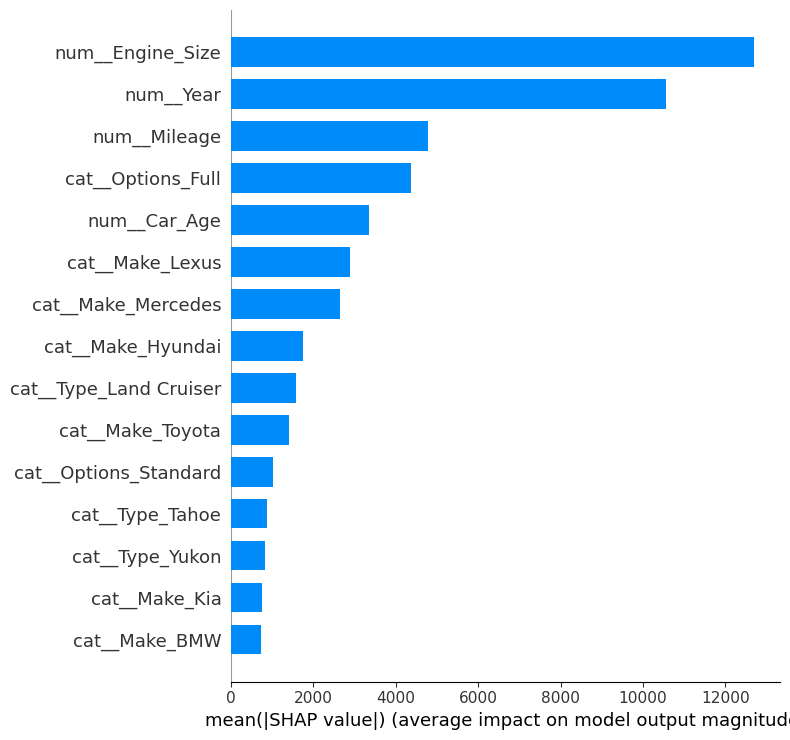

In [16]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)

Hasil **SHAP feature importance** menunjukkan bahwa faktor **teknis kendaraan** paling dominan dalam menentukan harga mobil bekas, dengan **Engine_Size**, **Year**, dan **Mileage** sebagai tiga kontributor terbesar terhadap prediksi model. Fitur turunan seperti **Car_Age** juga berpengaruh signifikan, mengonfirmasi bahwa usia kendaraan menjadi penentu utama nilai pasar. Dari sisi kategorikal, **Options (Full)** serta merek tertentu seperti **Lexus**, **Mercedes**, dan **Toyota** memberikan kontribusi positif yang konsisten, sementara tipe kendaraan tertentu (misalnya **Land Cruiser**, **Tahoe**, **Yukon**) turut memengaruhi harga namun dengan dampak lebih kecil.


## 3.7 Save Artefak Model Final Terbaik

In [17]:
import joblib
from pathlib import Path
from datetime import datetime

# =========================
# 1. Folder Model (naik 1 level)
# =========================
MODELS_DIR = Path('..') / 'Model'
MODELS_DIR.mkdir(exist_ok=True)

# =========================
# 2. Ambil model inti dari pipeline
# =========================
model_core = best_xgb_model.named_steps['model']

# Nama class model (misalnya: XGBRegressor)
raw_model_name = type(model_core).__name__

# Rapikan untuk nama file
model_name_clean = raw_model_name.lower().replace('regressor', '')

# =========================
# 3. Ambil metrik utama
# =========================
test_mae = metrics_xgb_tuned['test_mae']
mae_str = f"{int(round(test_mae))}"

# =========================
# 4. Timestamp
# =========================
date_str = datetime.now().strftime('%Y%m%d')

# =========================
# 5. Definisikan model_path
# =========================
model_filename = f"{model_name_clean}_tuned_mae{mae_str}_{date_str}.joblib"
model_path = MODELS_DIR / model_filename

# =========================
# 6. Simpan model final
# =========================
joblib.dump(best_xgb_model, model_path)

print(f"Model saved to: {model_path.resolve()}")

Model saved to: C:\Users\U1\Documents\arabian-cars-1\Model\xgb_tuned_mae11198_20251218.joblib


**Model terbaik hasil tuning** disimpan secara otomatis ke folder **`Model/` satu level di atas notebook**, dengan nama file yang dibuat **dinamis** berdasarkan jenis model, nilai **test MAE**, dan **tanggal penyimpanan**. Prosesnya mencakup pembuatan direktori jika belum ada, ekstraksi nama model dari pipeline, pembentukan nama file yang informatif untuk keperluan versioning, serta penyimpanan model menggunakan `joblib`, sehingga model siap langsung digunakan pada tahap deployment tanpa pelatihan ulang.
